In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sbi.utils import BoxUniform
from torch.distributions.multivariate_normal import MultivariateNormal


from data.data_generators import SBIGaussian2d
from plot import plot_2d_pdf_on_grid, plot_2d_pdf_contours

from nde.flows import construct_maf
from nde.train import train

from tqdm import tqdm
import os

In [2]:
B = 100_000
B_PRIME = 10_000
B_DOUBLE_PRIME = 10_000
N_SAMPLES_POSTERIOR = 50_000

PATH_EXPERIMENT = 'saved_experiments/SBIGaussian2d/'

## SBI Task: Simulator, Prior and True/Target Posterior 

In [3]:
# SBI Task: Inference of 2d Gaussian Mean under uniform prior

# Prior
low_, high_ = -10, 10
prior = BoxUniform(
    low=torch.FloatTensor([low_, low_]), high=torch.FloatTensor([high_, high_])
)

# Data Generator
data_gen = SBIGaussian2d(prior=prior)

# Simulator
simulator = data_gen.simulator

In [4]:
# Observation
filename = PATH_EXPERIMENT + "groundtruth_observation.pkl"
if os.path.exists(filename):
    observation = torch.load(filename)
    theta_true, x_obs = observation["theta_true"], observation["x_obs"]
else:
    theta_true = torch.FloatTensor([1, 1])  # true parameters
    x_obs = simulator(theta_true)  # x_0 ~ simulator(theta_true)
    observation = {"theta_true": theta_true, "x_obs": x_obs}
    torch.save(observation, "groundtruth_observation.pkl")

# True posterior: P(theta|x_0)
true_posterior_pdf = data_gen.true_posterior_pdf(x_obs)


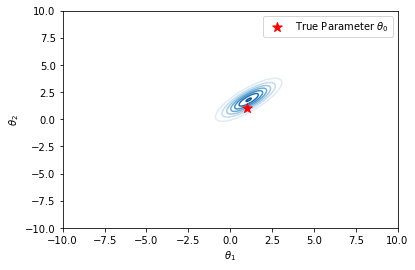

In [6]:
# Plot P(theta|x_0), x_0 ~ simulator(theta_true)
plt.scatter(theta_true[0], theta_true[1], marker="*", color="red", s=100, zorder=1, label=r'True Parameter $\theta_0$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plot_2d_pdf_on_grid(true_posterior_pdf, low_, high_)
plt.legend()
plt.show()


The simulator is stochastic, meaning that a generated observation `x_obs` might not correspond to the most probable one. In this case, the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ is centered around $x_0$=`x_obs` and not $\theta_0$=`theta_true`.

Indeed: $p(\theta \mid x_0) = p(x_0\mid \theta)p(\theta)/p(x_0) = p(x_0\mid \theta)$ because $p(\theta) \sim \mathcal{U}(0,1)$ is uniform. Finally we have that $p(\theta \mid x_0) = p(x_0\mid \theta) =p_{\mathcal{N}(\theta, \Sigma)}(x_0) = p_{\mathcal{N}(x_0, \Sigma)}(\theta) = \mathcal{N}(x_0, \Sigma)$ because of the symmetry of the gaussian distribution.

In order to solve this stochasticity problem and get a posterior centered around the true parameters `theta_true` (i.e. that generated `x_obs`), we would need more than one observation simulated using the true parameter $\theta_0$ to get an empirical approximation of the mean of the simulator likelihood:
$$x_i \sim p(x\mid \theta_0) = \mathcal{N}(\theta_0,\Sigma) \rightarrow x_{mean} = \frac{1}{n}\sum x_i \approx \theta_0$$

So $p(\theta \mid x_{mean}) \approx p(\theta \mid \theta_0) =\mathcal{N}(\theta_0, \Sigma)$.



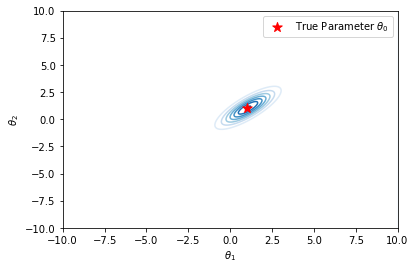

In [7]:
# Plot p(theta|mean(x_1,...,x_10)), x_i ~ simulator(theta_true)
x_obs_100 = torch.stack([simulator(theta_true) for i in range(100)])
true_posterior_100_pdf = data_gen.true_posterior_pdf(x_obs_100)
plt.scatter(theta_true[0], theta_true[1], marker="*", color="red", s=100, zorder=1, label=r'True Parameter $\theta_0$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plot_2d_pdf_on_grid(true_posterior_100_pdf, low_, high_)
plt.legend()
plt.show()

## Data Generation

In [7]:
# Simulate Data, create datasets
filename = PATH_EXPERIMENT+'datasets.pkl'

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    b_theta, b_x = data_gen.get_joint_data(B)
    b_prime_theta, b_prime_x = data_gen.get_joint_data(B_PRIME)
    b_double_prime_theta, b_double_prime_x = data_gen.get_joint_data(B_DOUBLE_PRIME)

    datasets = {
        "B": (b_theta, b_x),
        "B_prime": (b_prime_theta, b_prime_x),
        "B_double_prime": (b_double_prime_theta, b_double_prime_x),
    }
    torch.save(datasets, PATH_EXPERIMENT+'datasets.pkl')


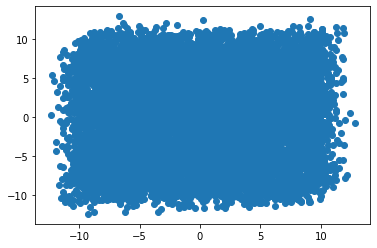

In [9]:
# Simulations Covered Space 
plt.scatter(datasets['B_prime'][1][:,0], datasets['B_prime'][1][:,1])


## Train Estimator: NPE (MAF)
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$

In [10]:
# TRAIN/ LOAD TRAINED FLOWS
# Good MAF trained on X=(X_1,X_2)
filename = PATH_EXPERIMENT+'maf_good.pkl'

if os.path.exists(filename):
    maf_good = torch.load(filename)
else: 
    maf_good = construct_maf(
        b_theta, hidden_features=50, context_features=2, standardize_transform=False
    )

    best_val_loss_good, epochs_good = train(
        maf_good,
        datasets['B'][0], # Theta
        context=datasets['B'][1],  # X=(X_1,X_2)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

    # save flow
    torch.save(maf_good, filename)

# # Bad MAF...
# maf_bad = construct_maf(
#     theta_train, hidden_features=50, context_features=1, standardize_transform=False
# )

# # trained on g(X)=(X_1)
# g = first_dim_only
# best_val_loss_bad, epochs_bad = train(
#     maf_bad,
#     theta_train,
#     context=g(x_train),  # g(X)=(X_1)
#     num_epochs=2000,
#     batch_size=10,
#     lr=0.005,
#     validation=True,
#     plot=False,
#     epochs_until_converge=20,
# )


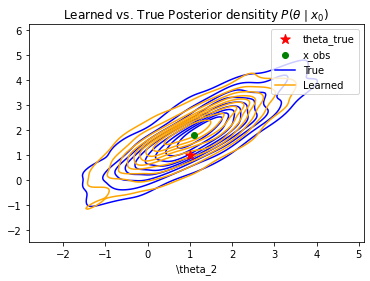

In [31]:
# Plot True vs. learned posteriors: P(theta | x_obs)

# samples from true posterior
true_posterior = data_gen.true_posterior(x_obs)
true_posterior_samples = true_posterior.sample((N_SAMPLES_POSTERIOR,))
# samples from learned posterior evaluated in x_obs
learned_posterior_samples = (
    maf_good.sample(N_SAMPLES_POSTERIOR, context=x_obs[:][None]).detach().numpy()[0]
)
# plot
plt.scatter(
    theta_true[0],
    theta_true[1],
    marker="*",
    s=100,
    color="red",
    label="theta_true",
    zorder=3,
)
plt.scatter(x_obs[0], x_obs[1], color="green", label="x_obs", zorder=3)
plt.xlabel(r"\theta_1")
plt.xlabel(r"\theta_2")
plot_2d_pdf_contours(
    true_posterior,
    maf_good,
    context=x_obs[:][None],
    title=r"Learned vs. True Posterior densitity $P(\theta\mid x_0)$",
)


## WALDO

$\tau^{\text{Waldo}} = (\mathbb{E}[\mathbf{\theta}|\mathbf{x}] - \theta_0)^T \Sigma^{-1} (\mathbb{E}[\mathbf{\theta}|\mathbf{x}] - \theta_0)$

In [11]:
posterior_stats = {'means': [], 'vars': []}
for i in tqdm(range(B_PRIME)):
    posterior_samples_qr = maf_good.sample(
        N_SAMPLES_POSTERIOR, context=datasets['B_prime'][1][i][None]
    )[0]
    posterior_stats['means'].append(torch.mean(posterior_samples_qr, dim=0))
    posterior_stats['vars'].append(torch.cov(torch.transpose(posterior_samples_qr, 0, 1)))


  2%|▏         | 163/10000 [02:06<2:06:08,  1.30it/s]

In [1]:
torch.save(posterior_stats, PATH_EXPERIMENT+'posterior_sats.pkl')

NameError: name 'torch' is not defined

In [ ]:
qr_statistics = np.array([
    torch.matmul(
        torch.matmul(torch.t(torch.subtract(posterior_means_qr[i].reshape(-1, 1), b_prime_theta[i, :].reshape(-1, 1))),
                     torch.linalg.inv(posterior_vars_qr[i])),
        torch.subtract(posterior_means_qr[i].reshape(-1, 1), b_prime_theta[i, :].reshape(-1, 1))).item()
    for i in tqdm(range(B_PRIME), desc='Computing QR statistics...')
])
qr_statistics.shape